In [35]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [36]:
# Load the data
path = 'Combined Data.csv'
df = pd.read_csv(path)

# Display the first few rows of the dataframe
print(df.head())

# EDA
print("Dataset Info:")
print(df.info())

print("Missing Values:")
print(df.isnull().sum())


   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [37]:
# Distribution of target labels
fig = px.histogram(df, x='status', title='Distribution of Mental Health Status')
fig.show()

# Handle NaN values in the statement column
df['statement'] = df['statement'].fillna('')



In [38]:
# Calculate text lengths
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))

# Create the histogram
fig = px.histogram(df, x='text_length', title='Text Length Distribution', nbins=50, template='plotly_dark')

# Calculate mean and median
mean_text_length = df['text_length'].mean()
median_text_length = df['text_length'].median()

# Add mean and median lines
fig.add_vline(x=mean_text_length, line_dash="dash", line_color="green", annotation_text="Mean", annotation_position="top left")
fig.add_vline(x=median_text_length, line_dash="dash", line_color="red", annotation_text="Median", annotation_position="top right")

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Text Length (Number of Words)',
    yaxis_title='Count',
    title_x=0.5,
    bargap=0.2,
    annotations=[
        dict(
            x=mean_text_length,
            y=max(df['text_length']),
            xref='x',
            yref='y',
            text='Mean',
            showarrow=True,
            arrowhead=2,
            ax=20,
            ay=-30
        ),
        dict(
            x=median_text_length,
            y=max(df['text_length']),
            xref='x',
            yref='y',
            text='Median',
            showarrow=True,
            arrowhead=2,
            ax=-20,
            ay=-30
        )
    ]
)

# Show the figure
fig.show()


In [39]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Victus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df['statement'].apply(augment_text)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augmented_statement']
df = pd.concat([df, augmented_df])

# Reapply preprocessing on augmented data
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

# Ensure no NaN values are left
df['cleaned_statement'] = df['cleaned_statement'].fillna('')


In [41]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=100)

# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(y.unique())}
y_int = y.map(label_map)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_int, test_size=0.2, random_state=42)


In [42]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_map), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10


c:\Users\Victus\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



2122/2122 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.6394 - loss: 0.9828 - val_accuracy: 0.7897 - val_loss: 0.5490
Epoch 2/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.8345 - loss: 0.4541 - val_accuracy: 0.8489 - val_loss: 0.4253
Epoch 3/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9159 - loss: 0.2499 - val_accuracy: 0.8745 - val_loss: 0.4031
Epoch 4/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9592 - loss: 0.1338 - val_accuracy: 0.8895 - val_loss: 0.4195
Epoch 5/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9719 - loss: 0.0969 - val_accuracy: 0.8948 - val_loss: 0.4761
Epoch 6/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9771 - loss: 0.0812 - val_accuracy: 0.8973 - val_loss: 0.5428
Epoch 7/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.9794 - loss: 0.0740 - val_accuracy: 0.8940 - val_loss: 0.5537
Epoch 8/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9810 - loss: 0.06

In [43]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluation
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_classes))

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))



664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8935 - loss: 0.6845
Test Accuracy: 0.8959845304489136
664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy Score:
0.8959845414270902
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1562
           1       0.94      0.96      0.95      6571
           2       0.87      0.89      0.88      6182
           3       0.86      0.84      0.85      4259
           4       0.85      0.80      0.83      1047
           5       0.93      0.89      0.91      1150
           6       0.81      0.80      0.80       447

    accuracy                           0.90     21218
   macro avg       0.88      0.87      0.88     21218
weighted avg       0.90      0.90      0.90     21218



In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(label_map.keys()),
    y=list(label_map.keys()),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()


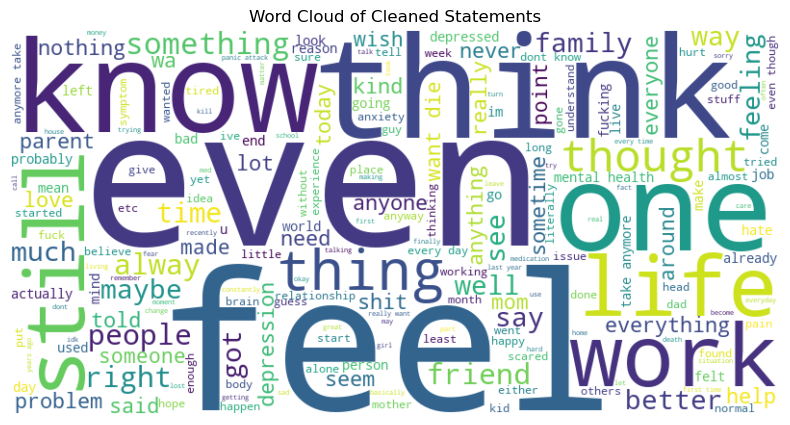

In [45]:
# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()




In [46]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()